In [1]:
import os
import torch
import torch.nn as nn
import time
import csv
import pandas as pd
from torch.utils.data import DataLoader
import torch.nn.functional as func
from bs4 import BeautifulSoup
import numpy as np
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')

import re
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
from torch.optim import Adam
from tqdm.auto import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path = r"/content/gdrive/MyDrive/nlp dataset/de-en/europarl-v7.de-en.en"
data_english = r"/content/gdrive/MyDrive/nlp dataset/de-en/europarl-v7.de-en.en"
data_german = r"/content/gdrive/MyDrive/nlp dataset/de-en/europarl-v7.de-en.de"

with open(os.path.join(data_english), "r") as file:
    data_english = file.readlines()

with open(os.path.join(data_german), "r") as file:
    data_german = file.readlines()


In [4]:
punct = string.punctuation
punct.replace('.', '')

def get_lower(text):
    return text.lower()

def remove_punctuations(text):
    return ''.join([char for char in text if char not in punct])

def tokenize(text):
    # text = text.strip()
    return word_tokenize(text)

def remove_alpha_numeric(sentence):
    # return ' '.join(word for word in tokens if word.isalpha())
    words = sentence.split()
    alphabetic_words = [word for word in words if word.isalpha()]
    return ' '.join(alphabetic_words)

def remove_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_extra_gaps(text):
    return ' '.join(text.split())

def pipeline(text):
    text = get_lower(text)
    text = remove_punctuations(text)
    tokens = tokenize(text)
    text = remove_alpha_numeric(text)
    text = remove_tags(text)
    text = remove_extra_gaps(text)
    return text

In [5]:
data = {}
maxi_english = 0
for sent in data_english:
    maxi_english = max(maxi_english, len(sent))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_english)

3951


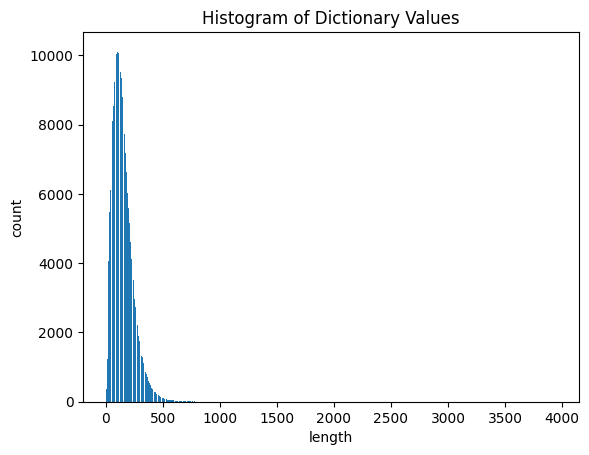

In [6]:
import matplotlib.pyplot as plt


keys = data.keys()
values = data.values()

plt.bar(keys, values)

# Add labels and a title
plt.xlabel('length')
plt.ylabel('count')
plt.title('Histogram of Dictionary Values')

# Show the plot
plt.show()


In [7]:
data = {}
maxi_german = 0
for sent in data_german:
    maxi_german = max(maxi_german, len(sent))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_german)

3632


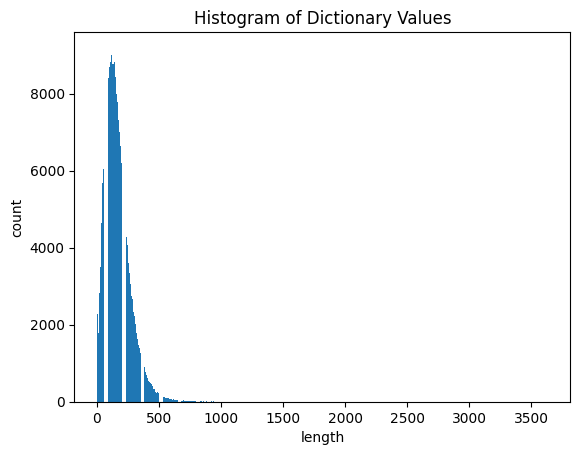

In [8]:
import matplotlib.pyplot as plt


keys = data.keys()
values = data.values()

plt.bar(keys, values)

# Add labels and a title
plt.xlabel('length')
plt.ylabel('count')
plt.title('Histogram of Dictionary Values')

# Show the plot
plt.show()


In [9]:
# df = pd.read_csv("Auguste_Maquet.txt", sep='', header=None, names="sentences")
df = pd.DataFrame({"english": data_english, "german": data_german})
print("Size : ", len(df))
df.head()

Size :  1920209


,english,german
0,Resumption of the session\n,Wiederaufnahme der Sitzungsperiode\n
1,I declare resumed the session of the European ...,"Ich erkläre die am Freitag, dem 17. Dezember u..."
2,"Although, as you will have seen, the dreaded '...","Wie Sie feststellen konnten, ist der gefürchte..."
3,You have requested a debate on this subject in...,Im Parlament besteht der Wunsch nach einer Aus...
4,"In the meantime, I should like to observe a mi...",Heute möchte ich Sie bitten - das ist auch der...


In [10]:
rows_to_drop = []
df['english'] = df['english'].str.lower()
df['german'] = df['german'].str.lower()
limit = 300  # For example, set your desired limit

for index, row in df.iterrows():
    if len(row['english']) > limit or len(row['german']) > limit:
        rows_to_drop.append(index)

df = df.drop(rows_to_drop)

print(df)

                                                   english  \
0                              resumption of the session\n   
1        i declare resumed the session of the european ...   
2        although, as you will have seen, the dreaded '...   
3        you have requested a debate on this subject in...   
4        in the meantime, i should like to observe a mi...   
...                                                    ...   
1920204  i would also like, although they are absent, t...   
1920205  i am not going to re-open the 'millennium or n...   
1920206                       adjournment of the session\n   
1920207  i declare the session of the european parliame...   
1920208           (the sitting was closed at 10.50 a.m.)\n   

                                                    german  
0                     wiederaufnahme der sitzungsperiode\n  
1        ich erkläre die am freitag, dem 17. dezember u...  
2        wie sie feststellen konnten, ist der gefürchte...  
3        im

In [11]:
m1, m2 = 0, 0
for index, row in df.iterrows():
    m1 = max(m1, len(row['english']))
    m2 = max(m2, len(row['german']))
print(m1, m2)

300 300


In [12]:
!pip install datasets -q


In [13]:
!pip install transformers -q

In [14]:
class SoftEmbedding(nn.Module):
  def __init__(self, wte, n_tokens):
      super(SoftEmbedding, self).__init__()
      self.wte = wte
      self.n_tokens = n_tokens
      self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte, n_tokens))

  def initialize_embedding(self, wte, n_token):
      return self.wte.weight[:n_tokens].clone().detach()

  def forward(self, tokens):
      input_embedding = self.wte(tokens[:, self.n_tokens:])
      learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
      return torch.cat([learned_embedding, input_embedding], 1)

In [15]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

tokenizer.add_special_tokens({"pad_token": "<pad>",
                              "bos_token": "<sos>",
                              "eos_token": "<eos>"
                             })
model.config.pad_token_id = tokenizer.pad_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

tokenizer.add_tokens(["<extract>"])
model.resize_token_embeddings(len(tokenizer))

n_tokens = 1

s_wte = SoftEmbedding(model.get_input_embeddings(), n_tokens=n_tokens)
model.set_input_embeddings(s_wte)

if torch.cuda.is_available():
    model = model.cuda()

In [16]:
# Fine-tuning parameters
batch_size = 4
epochs = 5
learning_rate = 1e-5
gradient_clip_value = 1.0

In [17]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

tokenizer.add_special_tokens({"pad_token": "<pad>",
                              "bos_token": "<sos>",
                              "eos_token": "<eos>"
                             })
model.config.pad_token_id = tokenizer.pad_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

tokenizer.add_tokens(["<extract>"])
model.resize_token_embeddings(len(tokenizer))

n_tokens = 1

s_wte = SoftEmbedding(model.get_input_embeddings(), n_tokens=n_tokens)
model.set_input_embeddings(s_wte)

if torch.cuda.is_available():
    model = model.cuda()

In [18]:
val = tokenizer("Grand Forks and Jamestown to the hepatitis A virus", max_length=20, truncation=True, padding="max_length", return_tensors="pt")

print(val.keys())

print(val["input_ids"])
print(val["attention_mask"])

dict_keys(['input_ids', 'attention_mask'])
tensor([[23581,  1114,   591,   290,  9986,   395,   593,   284,   262, 37439,
           317,  9471, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


In [19]:
model


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): SoftEmbedding(
      (wte): Embedding(50261, 768)
    )
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [20]:
class english_to_german(Dataset):
  def __init__(self, en2gr, tokenizer):
    self.data = en2gr
    self.english = self.data['english']
    self.german = self.data['german']
    self.X = []

    for english, german in zip(self.english, self.german):
        self.X.append("<sos> " + english + " <extract> " + german + " <eos>")

    self.encode = tokenizer(self.X, max_length=603, truncation=True, padding="max_length", return_tensors="pt")
    # self.encode = torch.cat([torch.full((1,n_tokens), 50261), self.encode], 1)
    self.attention_mask = self.encode['attention_mask']
    self.input_ids = self.encode['input_ids']

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return (self.input_ids[idx], self.attention_mask[idx])

In [35]:
dataset = english_to_german(df[:2000], tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size)

In [36]:
batch_size = 1

dataset_val = english_to_german(df[5000:5200], tokenizer)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)


In [37]:
for batch in dataloader:
    print(len(batch[0][0]), batch[0][0])
    print(len(batch[1][0]), torch.sum(batch[1][0]), batch[1][0])
    break

603 tensor([50258,   581, 24098,   286,   262,  6246,   198,   220, 50260,   266,
          798,   263,   559, 22184,   993,  1326,  4587,  1650,    89,  2150,
           82,   525,    72,  1098,   198,   220, 50259, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 502

In [38]:
optim = Adam(model.parameters(), lr=1e-3)
device = 'cuda'

In [39]:
parameters = list(model.parameters())
for x in parameters[1:]:
    x.requires_grad = False

In [40]:
epochs = 2
total_loss = 0
num_batches = 0
losses = []
rouges = []

for epoch in range(epochs):
    for ques, ans in tqdm(dataloader):
        # print(ques, ques.shape)
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        # print(ans, ans.shape)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        # print(loss)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        num_batches += 1
        losses.append(loss.item() / batch_size)
    avg_loss = total_loss / num_batches
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')
    if avg_loss <= 0.155:
        model.save_pretrained('gpt2_en2gr')


    val_loss = 0
    num_batches = 0
    for ques, ans in tqdm(dataloader_val):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        optim.step()

        val_loss += loss.item()
        num_batches += 1
        # losses.append(loss.item() / batch_size)
    avg_loss = val_loss / num_batches
    print(f'Epoch: {epoch+1}, VAL Loss: {avg_loss:.4f}')


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 1, Loss: 13.2504


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1, VAL Loss: 12.9818


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 2, Loss: 24.0912


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2, VAL Loss: 12.9818


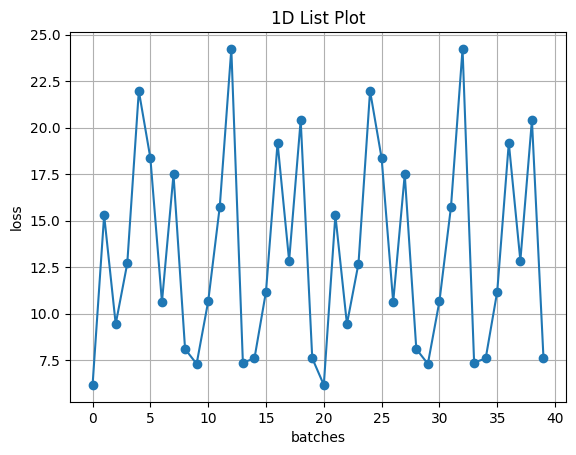

In [41]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# result = [10, 15, 20, 18, 25]

# Plot the data
plt.plot(losses[::100], marker='o')
plt.xlabel('batches')
plt.ylabel('loss')
plt.title('1D List Plot')
plt.grid(True)
plt.show()


DIFFERENT HYPERPARAMETER

In [55]:
epochs = 1
total_loss = 0
num_batches = 0
losses = []
rouges = []
optim = Adam(model.parameters(), lr=1e-1)

model = model.to('cuda')
for epoch in range(epochs):
    for ques, ans in tqdm(dataloader):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        # print(loss)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        num_batches += 1
        losses.append(loss.item() / batch_size)
    avg_loss = total_loss / num_batches
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')
    if avg_loss <= 0.155:
        model.save_pretrained('gpt2_cnn_daily')


    val_loss = 0
    num_batches = 0
    for ques, ans in tqdm(dataloader_val):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        optim.step()

        val_loss += loss.item()
        num_batches += 1
        # losses.append(loss.item() / batch_size)
    avg_loss = val_loss / num_batches
    print(f'Epoch: {epoch+1}, VAL Loss: {avg_loss:.4f}')


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 1, Loss: 13.2499


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1, VAL Loss: 12.9818


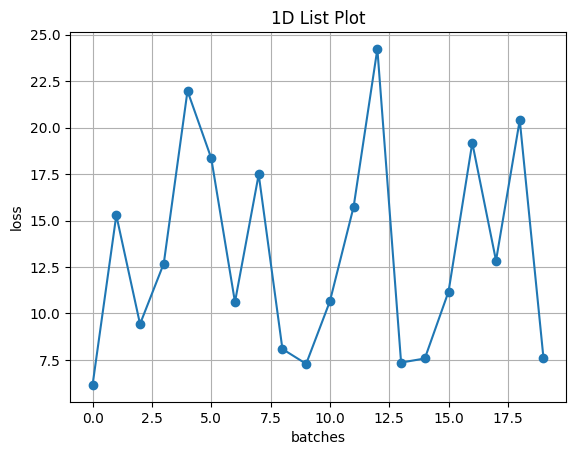

In [56]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# result = [10, 15, 20, 18, 25]

# Plot the data
plt.plot(losses[::100], marker='o')
plt.xlabel('batches')
plt.ylabel('loss')
plt.title('1D List Plot')
plt.grid(True)
plt.show()

In [42]:
trained_parameter = parameters[0]


In [43]:
model.save_pretrained("/content/gdrive/MyDrive/nlp dataset/gpt2_en2gr.pth")


In [44]:
no_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(no_of_parameters)

768


In [45]:
trained_parameter


Parameter containing:
tensor([[-1.5446e-01, -6.7761e-02,  8.7694e-03, -1.9818e-01, -1.0271e-01,
          2.5008e-01, -2.2772e-01, -1.3920e-01,  8.0824e-02, -2.8312e-01,
         -1.1900e-01, -3.4678e-02,  2.8761e-01, -2.1964e-01,  5.9996e-01,
          2.9405e-02,  4.0829e-02, -8.8866e-02, -2.1705e-01,  3.3100e-01,
         -3.8702e-02,  2.9162e-01,  1.8856e-02, -2.0368e-01,  2.4995e-01,
          3.4395e-02,  3.4970e-03,  3.3836e-02,  1.0471e-01,  1.4096e-01,
          8.4382e-02, -1.8380e-01, -3.1985e-01, -9.9541e-02,  7.5078e-02,
         -1.5676e-01, -2.7072e-01,  1.5686e-02, -1.0608e-01,  5.3475e-02,
         -1.9362e-01, -4.0835e-01,  3.0753e-02,  5.0578e-02,  4.2004e-02,
          2.3811e-01,  7.4849e-02,  1.1789e-01,  7.3123e-02, -2.0624e-01,
          1.8380e-01,  1.5671e-01, -2.5920e-02,  2.9016e-02,  1.6215e-01,
         -1.5735e-01,  7.8831e-02,  1.9581e-01,  8.9639e-02,  3.7289e-01,
         -4.2612e-01,  2.6689e-01,  8.8203e-02,  2.3243e-01, -1.5102e-01,
         -9.5242

In [46]:
def inference(input_text, model):
    model = model.to('cpu')
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), input_ids], 1)
    # print(input_ids)
    output_ids = model.generate(input_ids, max_length=200, num_beams=5, no_repeat_ngram_size=2, top_k=50)
    output_ids = output_ids
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text

In [47]:
from nltk.translate.bleu_score import sentence_bleu

def find_bleu(reference_tokens, candidate_tokens):
    print("required : ", reference_tokens)
    print("Predicted : ", candidate_tokens)
    mini = min(len(candidate_tokens.split()), len(reference_tokens.split()))
    reference_tokens = [token.lower() for token in reference_tokens.split()]
    candidate_tokens = [token.lower() for token in candidate_tokens.split()]

    # Calculate BLEU score
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    # Print the BLEU score
    print("BLEU Score:", bleu_score)


In [54]:
for i in range(1200,1205):
    find_bleu(df.loc[i]['english'], inference(df.loc[i]['german'], model))

required :  no other member state is at such a disadvantage.

Predicted :  kein anderer mitgliedstaat ist derart benachteiligt.

BLEU Score: 0
required :  mr president, the monopolies' ban is the key element of functioning competition order in europe.

Predicted :  herr präsident, meine sehr verehrten damen und herren, liebe kolleginnen und kollegen!

BLEU Score: 0
required :  the commission deemed the practical administration relating to the monitoring of the monopolies' ban to be unsatisfactory, something i would wholeheartedly agree with.

Predicted :  das kartellverbot ist das kernstück einer funktionierenden wettbewerbsordnung in europa. die praktische handhabung der überwachung des kartellverbots ist von der kommission als unbefriedigend empfunden worden; dem ist zunächst auch zuzustimmen.

BLEU Score: 0
required :  but opinion differs as to the solution.

Predicted :  aber im hinblick auf die lösung gehen die meinungen auseinander.

BLEU Score: 0
required :  the commission' s pr